# About tnc-edge-gps-speed

This notebook uses gps data points (lat+lon every minute) to generate heading and speed data.


In [20]:
import pandas
import numpy as np
from datetime import datetime, date, time, timezone, timedelta
from dateutil.parser import parse as parse_datetime
# help(np.argwhere)
import re
import awswrangler as wr
import boto3
import math
boto3.setup_default_session(profile_name='XXXXXXXX')


In [92]:
gps_df = wr.athena.read_sql_query("SELECT datetime ,gps_datetime ,lat ,lon from stpatrick_v1_gpsdata where gps_datetime > '2024-01-01';", database="tnc_edge")


gps_df

,datetime,gps_datetime,lat,lon
0,2024-02-07 12:28:46.91159-08,2024-02-07 12:10:22-08,8.060846,-87.4912209
1,2024-02-07 12:28:46.91159-08,2024-02-07 12:11:22-08,8.0605715,-87.4908129
2,2024-02-07 12:28:46.91159-08,2024-02-07 12:12:22-08,8.0603253,-87.4904484
3,2024-02-07 12:28:46.91159-08,2024-02-07 12:13:22-08,8.0600913,-87.4900765
4,2024-02-07 12:28:46.91159-08,2024-02-07 12:14:22-08,8.059865,-87.4896791
...,...,...,...,...
54831,2024-01-15 05:41:23.158786-08,2024-01-15 05:33:58-08,5.1234846,-85.2465634
54832,2024-01-15 05:41:23.158786-08,2024-01-15 05:34:58-08,5.1247323,-85.2462548
54833,2024-01-15 05:41:23.158786-08,2024-01-15 05:35:58-08,5.126158,-85.2456425
54834,2024-01-15 05:41:23.158786-08,2024-01-15 05:36:58-08,5.1275533,-85.2449263


In [95]:
if gps_df['lat'].dtype != 'float64':
    gps_df['lat'] = pandas.to_numeric(gps_df['lat'])
if gps_df['lon'].dtype != 'float64':
    gps_df['lon'] = pandas.to_numeric(gps_df['lon'])
if gps_df['gps_datetime'].dtype != 'object':
    gps_df['gps_datetime'] = pandas.to_datetime(gps_df['gps_datetime'])


gps_df = gps_df.sort_values('gps_datetime')
    

gps_df['prev_lat'] = gps_df['lat'].shift(1)
gps_df['prev_lon'] = gps_df['lon'].shift(1)
gps_df['prev_dt'] = gps_df['gps_datetime'].shift(1)

if gps_df['prev_dt'].dtype != 'object':
    gps_df['prev_dt'] = pandas.to_datetime(gps_df['prev_dt'])


gps_df['kph'] = np.power(
    np.power((gps_df['lat'] - gps_df['prev_lat'])*110.574, 2) + 
    np.power(np.cos(gps_df['lat']*3.14159265/180)*(gps_df['lon']-gps_df['prev_lon'])*111.320, 2), 0.5
    )/((gps_df['gps_datetime'] - gps_df['prev_dt']).dt.total_seconds()/3600)

gps_df['clockheading'] = (6 - 
    np.sign(gps_df['lon']-gps_df['prev_lon'])
    *(np.sign(gps_df['lon']-gps_df['prev_lon'])
      *np.arctan(
          (gps_df['lat'] - gps_df['prev_lat'])
          /(np.cos(gps_df['lat']*3.14159265/180)*(gps_df['lon']-gps_df['prev_lon'])))/3.14159 + 0.5 )
    * 6 )

# if the lon difference == 0, then the math above can't tell if it's north or south. It defaults to south (6).
# check here and conditionally set to north
gps_df.loc[(gps_df['lon']-gps_df['prev_lon'] == 0) & ( gps_df['lat'] - gps_df['prev_lat'] > 0), 'clockheading'] = 0

gps_df

,datetime,gps_datetime,lat,lon,prev_lat,prev_lon,prev_dt,kph,clockheading
29641,2024-01-02 10:51:19.377231-08,2024-01-02 10:46:46-08:00,9.436328,-84.168006,NaN,NaN,NaN,NaN,NaN
29642,2024-01-02 10:51:19.377231-08,2024-01-02 10:47:46-08:00,9.436392,-84.167904,9.436328,-84.168006,2024-01-02 10:46:46-08:00,0.790045,1.921934
29643,2024-01-02 11:06:09.281769-08,2024-01-02 10:48:46-08:00,9.436390,-84.167906,9.436392,-84.167904,2024-01-02 10:47:46-08:00,0.015643,8.067730
29644,2024-01-02 11:06:09.281769-08,2024-01-02 10:49:46-08:00,9.436378,-84.167905,9.436390,-84.167906,2024-01-02 10:48:46-08:00,0.085838,5.854238
29645,2024-01-02 11:06:09.281769-08,2024-01-02 10:50:46-08:00,9.436378,-84.167919,9.436378,-84.167905,2024-01-02 10:49:46-08:00,0.094229,9.027076
...,...,...,...,...,...,...,...,...,...
5393,2024-03-18 09:15:51.998517-07,2024-03-18 09:05:41-07:00,6.514401,-89.151215,6.514657,-89.151327,2024-03-18 09:04:41-07:00,1.856277,5.216461
5384,2024-03-18 09:15:51.998517-07,2024-03-18 09:06:41-07:00,6.514089,-89.151097,6.514401,-89.151215,2024-03-18 09:05:41-07:00,2.211703,5.316722
5385,2024-03-18 09:15:51.998517-07,2024-03-18 09:07:41-07:00,6.513754,-89.150948,6.514089,-89.151097,2024-03-18 09:06:41-07:00,2.434919,5.204991
5386,2024-03-18 09:15:51.998517-07,2024-03-18 09:08:41-07:00,6.513404,-89.150811,6.513754,-89.150948,2024-03-18 09:07:41-07:00,2.493554,5.290504


In [101]:
# gps_df.dtypes
# gps_df[elog_df['kph'] > 13]

# gps_df[elog_df['lon']-elog_df['prev_lon'] == 0]

# gps_df.loc[range(30465,30485)]

# gps_df['gps_datetime']
gps_df[gps_df['kph'] <= 0.1]

# gps_df[gps_df['gps_datetime'] - gps_df['prev_dt'] <= np.timedelta64(0) ]


,datetime,gps_datetime,lat,lon,prev_lat,prev_lon,prev_dt,kph,clockheading
29643,2024-01-02 11:06:09.281769-08,2024-01-02 10:48:46-08:00,9.436390,-84.167906,9.436392,-84.167904,2024-01-02 10:47:46-08:00,0.015643,8.067730
29644,2024-01-02 11:06:09.281769-08,2024-01-02 10:49:46-08:00,9.436378,-84.167905,9.436390,-84.167906,2024-01-02 10:48:46-08:00,0.085838,5.854238
29645,2024-01-02 11:06:09.281769-08,2024-01-02 10:50:46-08:00,9.436378,-84.167919,9.436378,-84.167905,2024-01-02 10:49:46-08:00,0.094229,9.027076
29647,2024-01-02 11:06:09.281769-08,2024-01-02 10:52:46-08:00,9.436375,-84.167935,9.436362,-84.167934,2024-01-02 10:51:46-08:00,0.085128,11.867744
29649,2024-01-02 11:06:09.281769-08,2024-01-02 10:54:46-08:00,9.436384,-84.167922,9.436387,-84.167914,2024-01-02 10:53:46-08:00,0.056960,8.314043
...,...,...,...,...,...,...,...,...,...
32334,2024-03-08 11:00:29.087787-08,2024-03-08 10:40:38-08:00,9.436681,-84.167754,9.436678,-84.167739,2024-03-08 10:39:38-08:00,0.099794,9.346962
32327,2024-03-08 11:00:29.087787-08,2024-03-08 10:44:38-08:00,9.436697,-84.167707,9.436699,-84.167706,2024-03-08 10:43:38-08:00,0.014676,6.606732
32328,2024-03-08 11:00:29.087787-08,2024-03-08 10:46:38-08:00,9.436687,-84.167724,9.436679,-84.167712,2024-03-08 10:45:38-08:00,0.091756,10.150370
21291,2024-03-16 16:54:39.632027-07,2024-03-16 16:46:37-07:00,6.506648,-89.514805,6.506647,-89.514803,2024-03-16 16:45:37-07:00,0.017253,9.758388


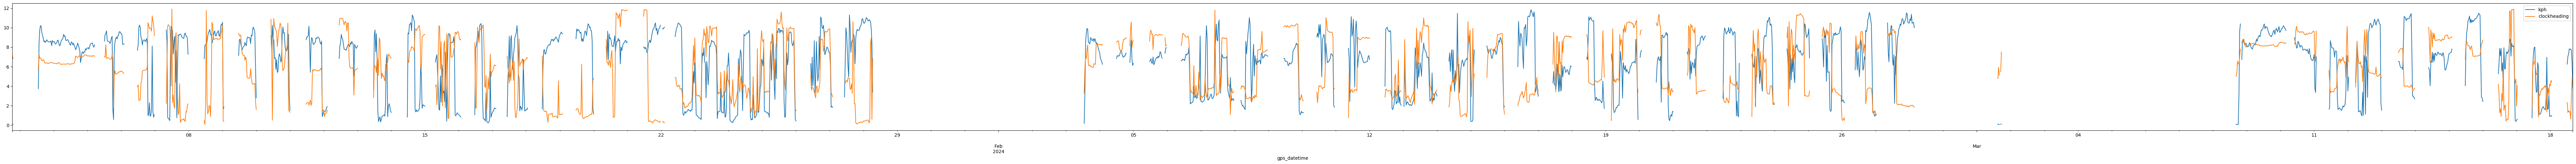

In [103]:

gps_df['gps_datetime'] = pandas.to_datetime(gps_df['gps_datetime'], utc=True)


avg = gps_df.groupby('gps_datetime').mean()[['kph', 'clockheading']]

# i = pandas.DatetimeIndex([gps_df['gps_datetime'].min(), gps_df['gps_datetime'].max()])
# gps_df_ts = pandas.DataFrame(index=i)
#     df['mycol'] = [0, 0]
gps_df_ts = avg.resample(timedelta(minutes=30)).mean()

gps_df_ts.plot(figsize=(100,5))